In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 분석 목적 (Objective)

월마트의 45개의 매장 정보와 월별 매출을 담은 데이터  
월마트는 휴일이 매출에 미치는 영향을 알고 싶어함 (-> 데이터에 휴일 정보 있음)  
분석 목적은 주별 매출을 예측하는 것! + 휴일의 영향 분석

# 데이터 탐색 (Data Exploration)

**2010-02-05 ~ 2012-11-01 월마트 sales 데이터**
- **Store** : the store number
- **Date** : the week of sales
- **Weekly_Sales** : sales for the given store
- **Holiday_Flag** : whether the week is a special holiday week 1 - Holiday week 0 – Non-holiday week
- **Temperature** : Temperature on the day of sale
- **Fuel_Price** : Cost of fuel in the region
- **CPI** : Prevailing consumer price index
- **Unemployment** : Prevailing unemployment rate
- **Holiday Events**
    - Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
    - Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
    - Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
    - Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [5]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

#from brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [8]:
# Date를 년, 월, 요일로 변환

df.Date=pd.to_datetime(df.Date) # datetime 형변환

df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month
#df['month_quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
#                                     8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'}) # 분기
df['weekday'] = df.Date.dt.weekday

df.drop(['Date'], axis=1, inplace=True) # date컬럼 제거

In [9]:
target = 'Weekly_Sales'
features = [i for i in df.columns if i not in [target]] # feature 리스트생성
original_df = df.copy(deep=True)

print(features)

['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'weekday']


In [10]:
# 컬럼별 unique값 개수

df.nunique().sort_values()

Holiday_Flag       2
year               3
weekday            7
month             12
Store             45
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

In [11]:
# numerical과 categorical 변수 구분
nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; # nf:numerical 변수 리스트 / nnf 그 개수 / cf: categorical 변수 리스트 / ncf: 그 개수

for i in range(df[features].shape[1]): # shape[1]:열 개
    if nu.values[i]<=45:cf.append(nu.index[i]) # 45개(store개수) 미만이면 categorical / 그 외는 numerical
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 4 numerical & 5 categorical features.


In [12]:
print(df.info())
print("-------"*30)
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   year          6435 non-null   int64  
 8   month         6435 non-null   int64  
 9   weekday       6435 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 502.9 KB
None
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
             Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03 

# EDA

## Weekly_Sales (target 변수)

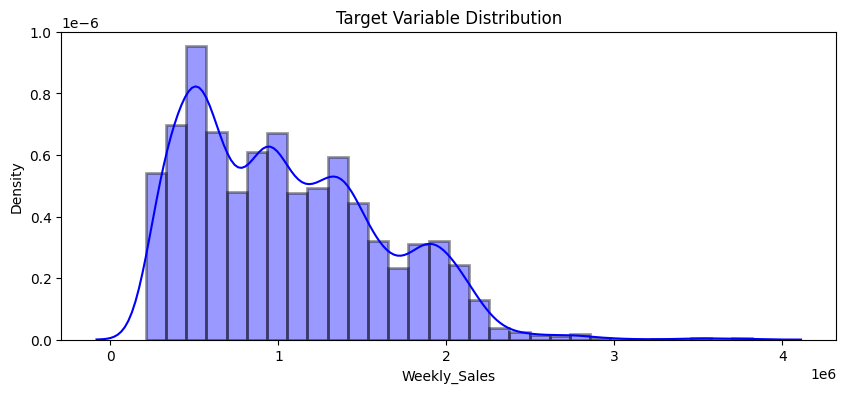

In [13]:
plt.figure(figsize=[10,4])
sns.distplot(df[target], color='b',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution')
plt.show()

# categorical 변수

                               Visualising Categorical Features:                                


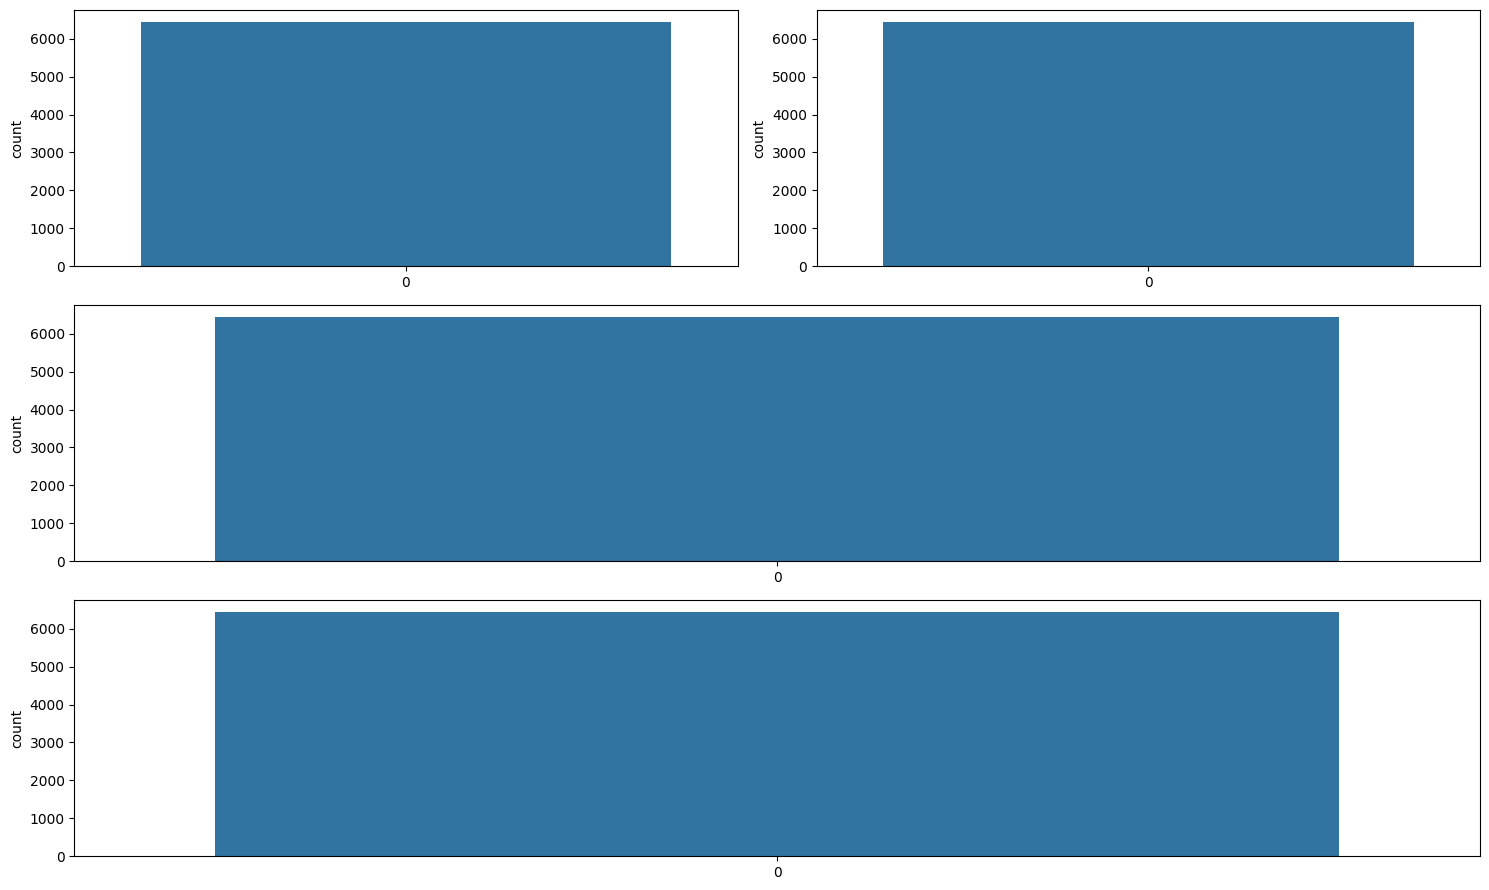

In [14]:
print('\033[1mVisualising Categorical Features:'.center(100))

n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=8:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-1)
        sns.countplot(df[cf[i]])
        
plt.tight_layout()
plt.show()

## numerical 변수

                                                Numeric Features Distribution                                                 


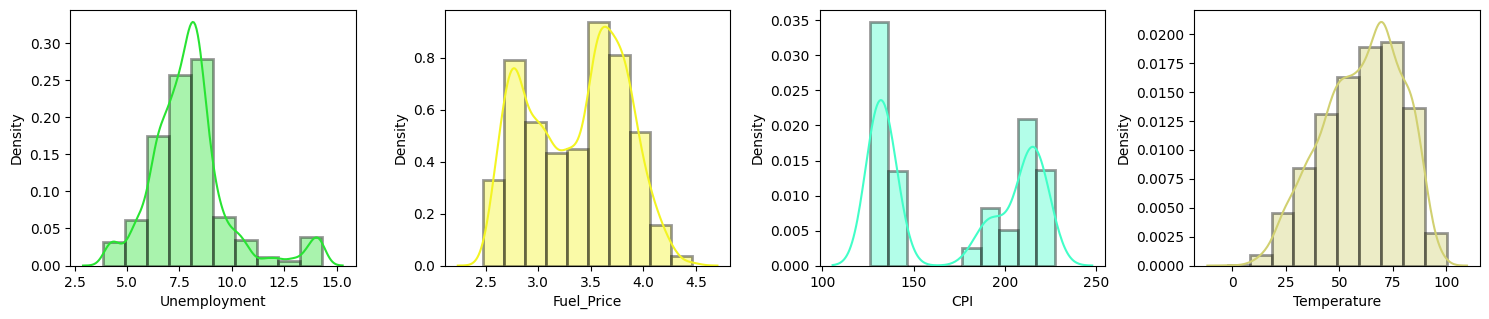

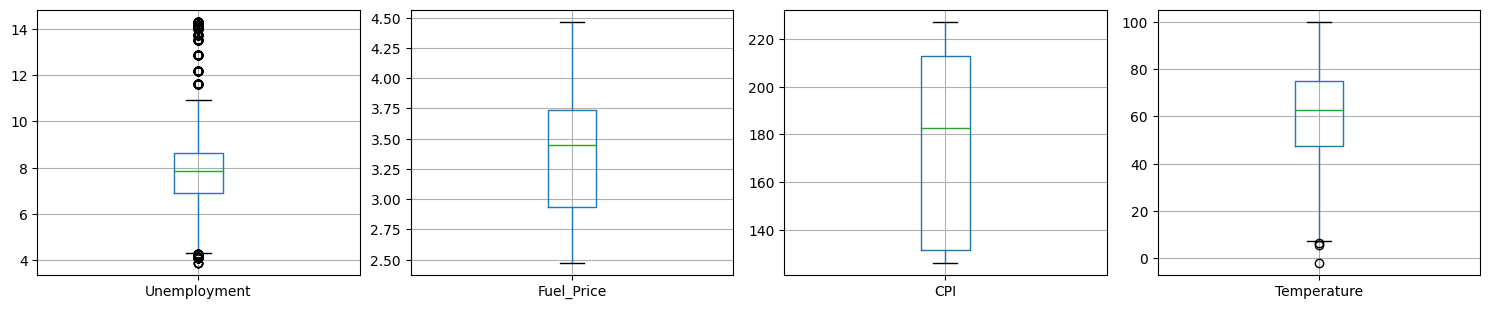

In [15]:
print('\033[1mNumeric Features Distribution'.center(130))

n=4

clr=['r','g','b','g','b','r']

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

outlier들이 보임

# 데이터 전처리 (Data Preprocessing)

In [16]:
# 중복행 제거

counter = 0
rs,cs = original_df.shape # 튜플형태 행,열 개수

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [17]:
# null값 체크

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

              Total Null Values  Percentage
Store                         0         0.0
Weekly_Sales                  0         0.0
Holiday_Flag                  0         0.0
Temperature                   0         0.0
Fuel_Price                    0         0.0
CPI                           0         0.0
Unemployment                  0         0.0
year                          0         0.0
month                         0         0.0
weekday                       0         0.0


In [18]:
# categorical 변수 인코딩

df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]

oh=True # 원핫인코딩
dm=True # 더미인코딩
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape
# categorical 변수 인코딩

df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]

oh=True # 원핫인코딩
dm=True # 더미인코딩
for i in fcc:
    
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    
    if (df3[i].nunique()>2):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape

One-Hot Encoding on features:
Holiday_Flag

Dummy Encoding on features:
year
weekday
month
Store
One-Hot Encoding on features:
Holiday_Flag

Dummy Encoding on features:
year
weekday
month
Store


(6435, 69)

In [19]:
# 이상치 제거

df1 = df3.copy()

features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
    
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,1643690.90,0,42.31,2.572,211.096358,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1641957.44,1,38.51,2.548,211.242170,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1611968.17,0,39.93,2.514,211.289143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1409727.59,0,46.63,2.561,211.319643,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1554806.68,0,46.50,2.625,211.350143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Inference:
Before removal of outliers, The dataset had 6435 samples.
After removal of outliers, The dataset now has 5953 samples.


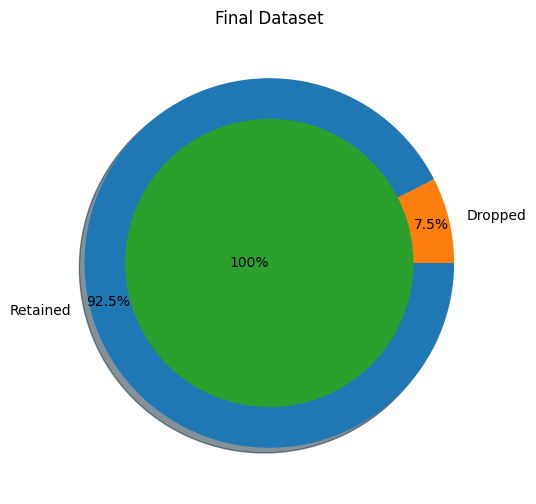


Inference: After the cleanup process, 482 samples were dropped, while retaining 7.49% of the data.


In [20]:
# 전처리 전후 결과 시각화

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

# 데이터 가공 (Data Manipulation)

In [21]:
# train, test 데이터셋 분리

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_')) # 변수명에 짝대기 제
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (5953, 68) (5953,) 
Training set  --->  (4762, 68) (4762,) 
Testing set   --->  (1191, 68)  (1191,)


In [22]:
# 피처 스케일링

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,weekday_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,...,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03
mean,-1.492110e-18,-1.305596e-16,-2.991680e-16,-2.762268e-16,-4.267434e-16,-5.520807e-17,1.939743e-17,4.513632e-17,1.492110e-18,-3.245339e-17,...,1.529413e-17,4.923963e-17,8.952659e-18,1.342899e-17,-3.730275e-18,-1.492110e-17,3.730275e-17,-2.984220e-17,-4.774752e-17,2.499284e-17
std,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,...,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00
min,-2.742012e-01,-2.961575e+00,-1.871814e+00,-1.248731e+00,-2.762670e+00,-7.526270e-01,-6.371530e-01,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
25%,-2.742012e-01,-7.314248e-01,-9.886990e-01,-1.076949e+00,-6.783836e-01,-7.526270e-01,-6.371530e-01,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
50%,-2.742012e-01,1.062547e-01,1.663112e-01,3.842133e-01,9.596435e-02,-7.526270e-01,-6.371530e-01,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
75%,-2.742012e-01,7.731979e-01,8.427860e-01,9.933828e-01,6.138095e-01,1.328679e+00,1.569482e+00,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
max,3.646958e+00,2.170008e+00,2.469806e+00,1.340791e+00,2.575491e+00,1.328679e+00,1.569482e+00,3.863473e+00,8.636394e+00,3.676723e+00,...,6.356783e+00,6.300861e+00,2.298067e+01,6.328643e+00,7.650163e+00,6.503146e+00,6.356783e+00,6.141290e+00,6.443435e+00,6.564495e+00



                                          Standardardization on Testing set                                          


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,weekday_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,...,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,0.005646,0.044406,0.075113,0.021041,-0.050953,0.052984,0.065042,0.007679,0.038532,0.026409,...,-0.004168,-0.017693,0.111140,-0.010959,-0.000055,0.030677,-0.004168,-0.056970,0.016556,0.045053
std,1.009885,1.000220,0.971917,1.004644,1.010206,1.014188,1.028250,1.014142,1.152364,1.044095,...,0.987401,0.944330,1.881448,0.965939,1.000214,1.093088,0.987401,0.810380,1.051077,1.134875
min,-0.274201,-2.857425,-1.780457,-1.248731,-2.762670,-0.752627,-0.637153,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
25%,-0.274201,-0.657516,-0.852751,-1.077025,-0.699355,-0.752627,-0.637153,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
50%,-0.274201,0.187351,0.298996,0.393492,0.058860,-0.752627,-0.637153,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
75%,-0.274201,0.818764,0.844961,1.019967,0.611390,1.328679,1.569482,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
max,3.646958,2.035481,2.469806,1.345814,2.575491,1.328679,1.569482,3.863473,8.636394,3.676723,...,6.356783,6.300861,22.980668,6.328643,7.650163,6.503146,6.356783,6.141290,6.443435,6.564495


# 변수 선택 (Feature selection)

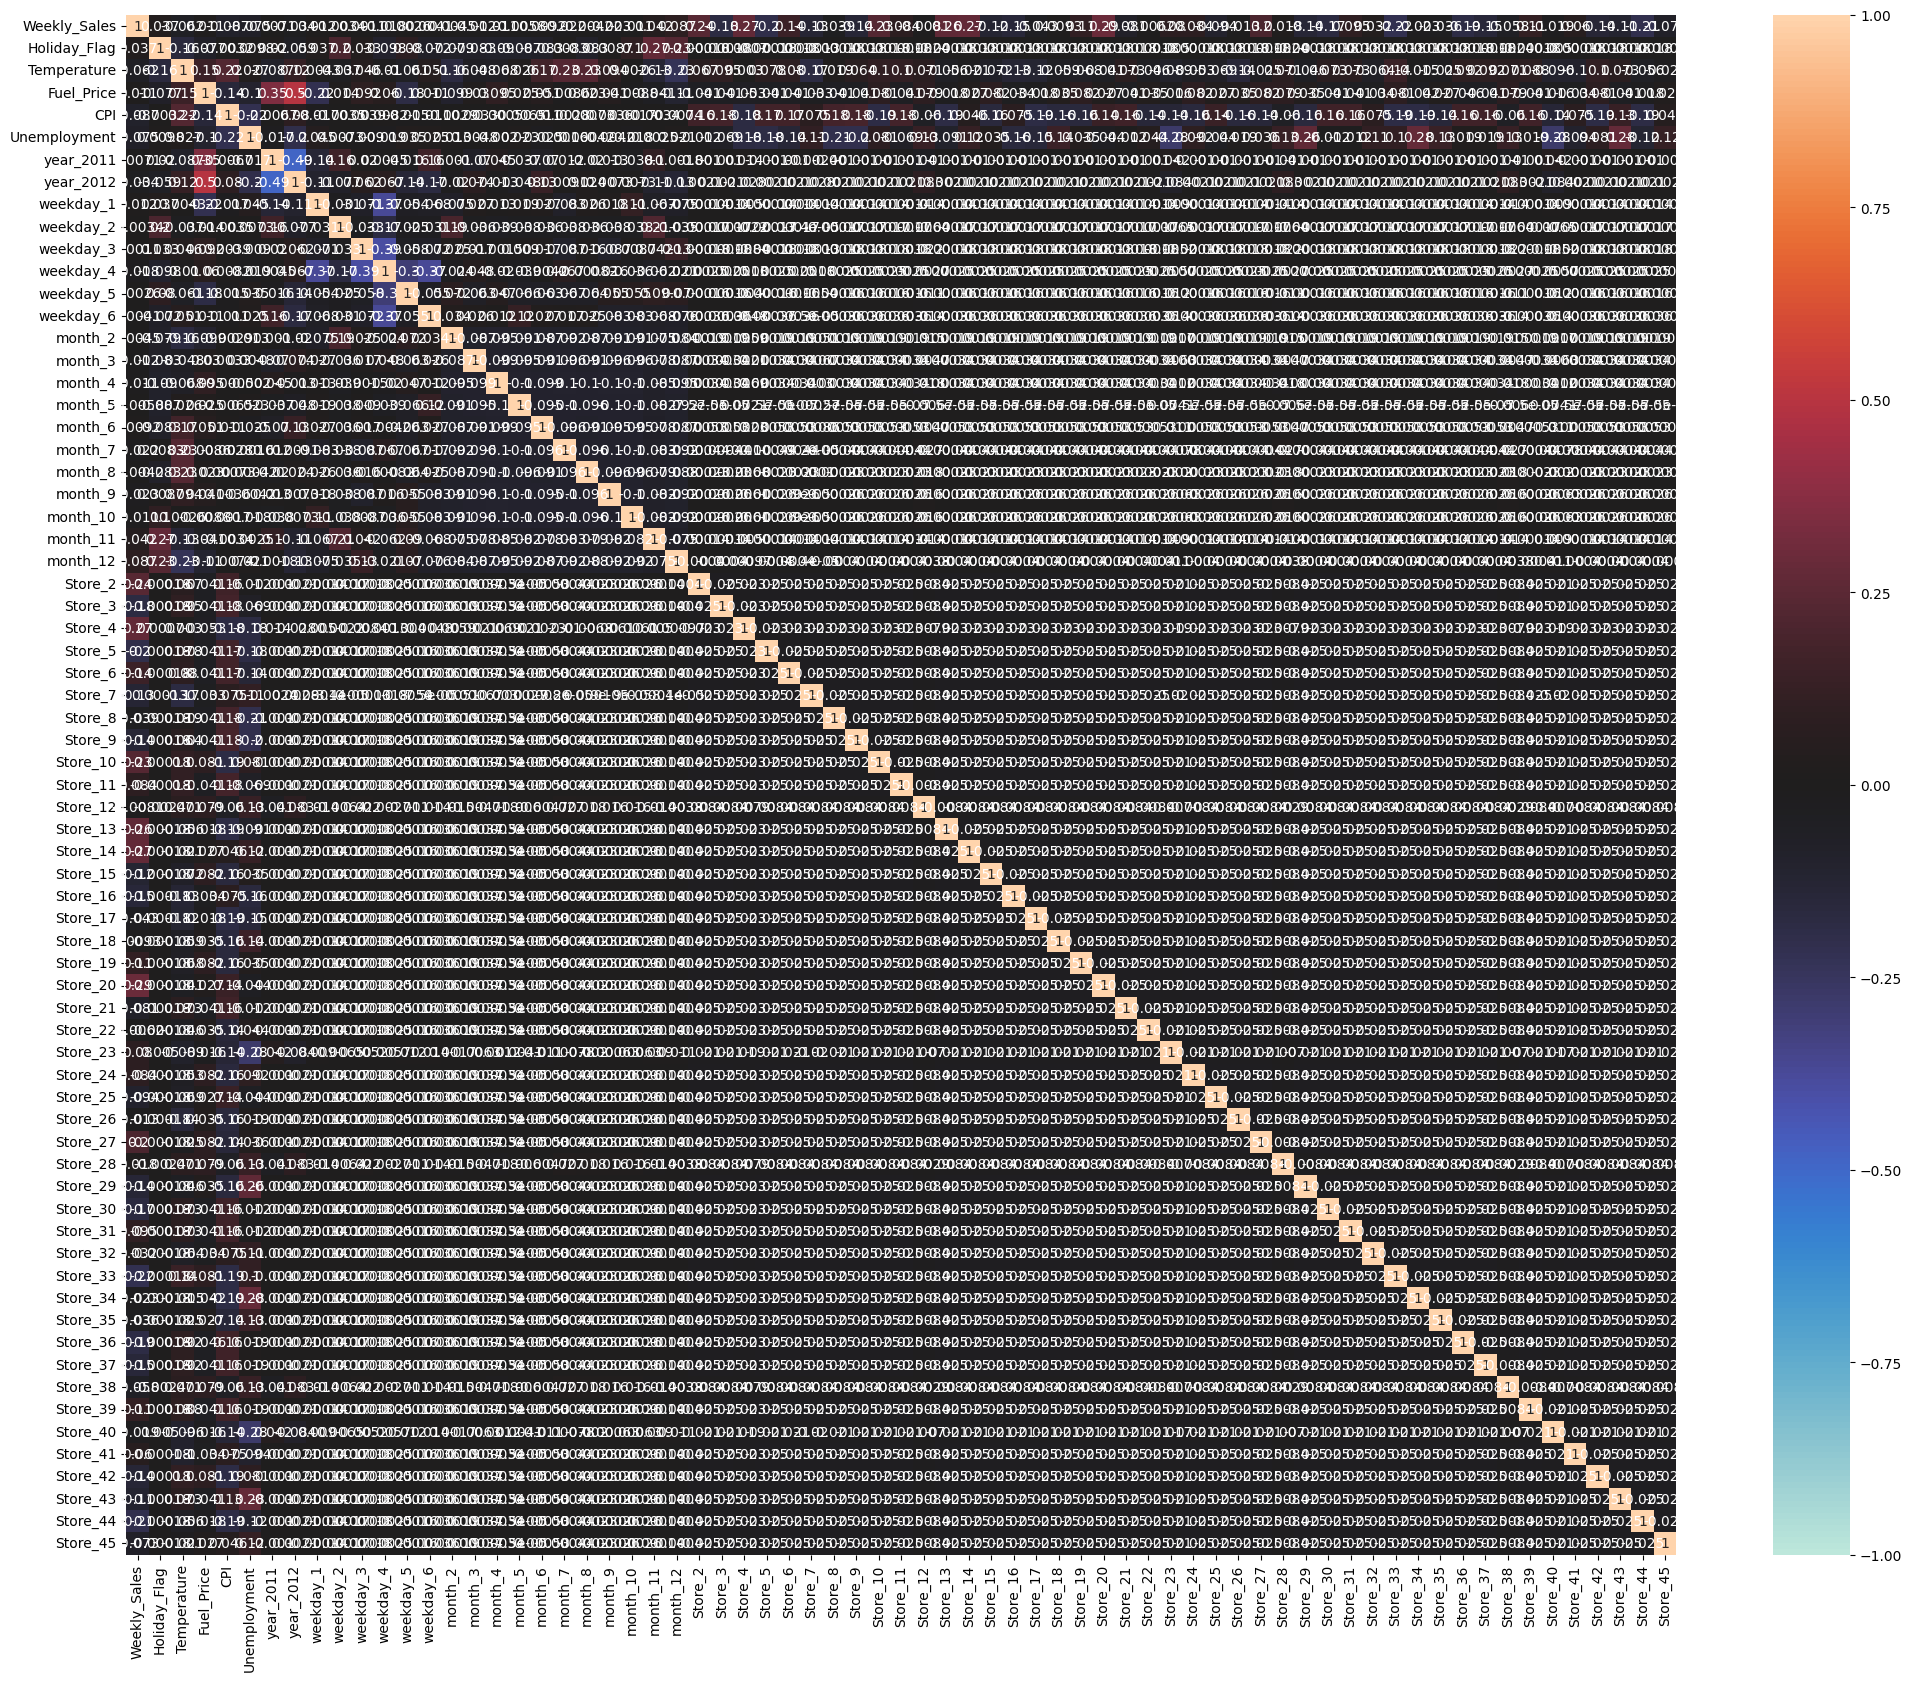

In [23]:
# 히트맵

plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

일부 상관관계 높은 변수들이 보임

In [24]:
# 선형회귀 돌려보기

Train_xy = pd.concat([Train_X_std,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     958.4
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:55:34   Log-Likelihood:                -63430.
No. Observations:                4762   AIC:                         1.270e+05
Df Residuals:                    4693   BIC:                         1.274e+05
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.048e+06   2152.234    486.752      0.000    1.04e+06    1.05e+06
Holiday_Flag  3435.7934   2436.850      1.410      0.159   -1341.577    8213.164
Temperature  -1.091e+04   3611.329     -3.022      0.003    -1.8e+04   -3834.746
Fuel_Price    4743.1404   6083.604      0.780      0.436   -7183.581    1.67e+04
CPI           4.806e+05   6.53e+04      7.359      0.000    3.53e+05    6.09e+05
Unemployment -6.096e+04   7305.771     -8.344      0.000   -7.53e+04   -4.66e+04
year_2011    -3.085e+04   6385.220     -4.832      0.000   -4.34e+04   -1.83e+04
year_2012    -7.005e+04   8794.662     -7.965      0.000   -8.73e+04   -5.28e+04
weekday_1     5298.1880   3028.935      1.749      0.080    -639.948    1.12e+04
weekday_2    -1.144e+04   2552.678     -4.481      0.000   -1.64e+04   -6435.135
weekday_3    -1.397e+04   3035.015     -4.603      0.000   -1.99e+04   -8021.037
weekday_4    -1.668e+04   4056.274     -4.113      0.000   -2.46e+04   -8730.185
weekday_5    -1.288e+04   2827.562     -4.555      0.000   -1.84e+04   -7335.388
weekday_6    -2292.8321   3074.313     -0.746      0.456   -8319.930    3734.265
month_2       2.869e+04   3169.875      9.050      0.000    2.25e+04    3.49e+04
month_3       2.018e+04   3233.395      6.243      0.000    1.38e+04    2.65e+04
month_4       2.099e+04   3462.153      6.062      0.000    1.42e+04    2.78e+04
month_5       2.214e+04   3478.401      6.364      0.000    1.53e+04     2.9e+04
month_6       3.159e+04   3270.641      9.659      0.000    2.52e+04     3.8e+04
month_7       1.905e+04   3478.984      5.474      0.000    1.22e+04    2.59e+04
month_8       2.445e+04   3357.585      7.282      0.000    1.79e+04     3.1e+04
month_9       1.231e+04   3456.199      3.561      0.000    5531.812    1.91e+04
month_10      1.696e+04   3519.751      4.820      0.000    1.01e+04    2.39e+04
month_11      4.132e+04   3243.964     12.736      0.000     3.5e+04    4.77e+04
month_12      6.241e+04   3556.769     17.546      0.000    5.54e+04    6.94e+04
Store_2       5.522e+04   2977.883     18.545      0.000    4.94e+04    6.11e+04
Store_3      -1.841e+05   3122.600    -58.973      0.000    -1.9e+05   -1.78e+05
Store_4       2.173e+05   2.14e+04     10.161      0.000    1.75e+05    2.59e+05
Store_5      -1.914e+05   3140.260    -60.961      0.000   -1.98e+05   -1.85e+05
Store_6      -9300.0797   3167.398     -2.936      0.003   -1.55e+04   -3090.492
Store_7      -1.058e+05   6373.008    -16.605      0.000   -1.18e+05   -9.33e+04
Store_8       -1.21e+05   3457.789    -34.980      0.000   -1.28e+05   -1.14e+05
Store_9      -1.635e+05   3269.593    -50.014      0.000    -1.7e+05   -1.57e+05
Store_10       2.18e+05   2.21e+04      9.844      0.000    1.75e+05    2.61e+05
Store_11     -4.043e+04   3138.072    -12.885      0.000   -4.66e+04   -3.43e+04
Store

## VIF 이용해서 다중공선성 해결

Dropped Features -->  ['CPI', 'Unemployment', 'Fuel_Price', 'weekday_4', 'month_7', 'Store_7', 'Temperature', 'month_12', 'Store_43', 'year_2012', 'Store_30', 'month_2', 'month_11', 'Store_16', 'month_5', 'Store_25', 'Store_29', 'month_10', 'Store_17', 'Holiday_Flag', 'Store_18', 'year_2011', 'Store_19', 'month_9', 'Store_20', 'Store_8', 'Store_34', 'Store_15', 'Store_22', 'month_6', 'Store_21', 'Store_35', 'Store_14', 'Store_13', 'Store_45', 'Store_27', 'month_3', 'weekday_1', 'Store_23', 'Store_44', 'Store_42', 'Store_11', 'weekday_5', 'Store_39', 'weekday_2', 'weekday_3', 'Store_24', 'Store_41', 'Store_40', 'Store_10', 'Store_36', 'Store_9', 'month_4', 'Store_2', 'Store_3', 'Store_6']


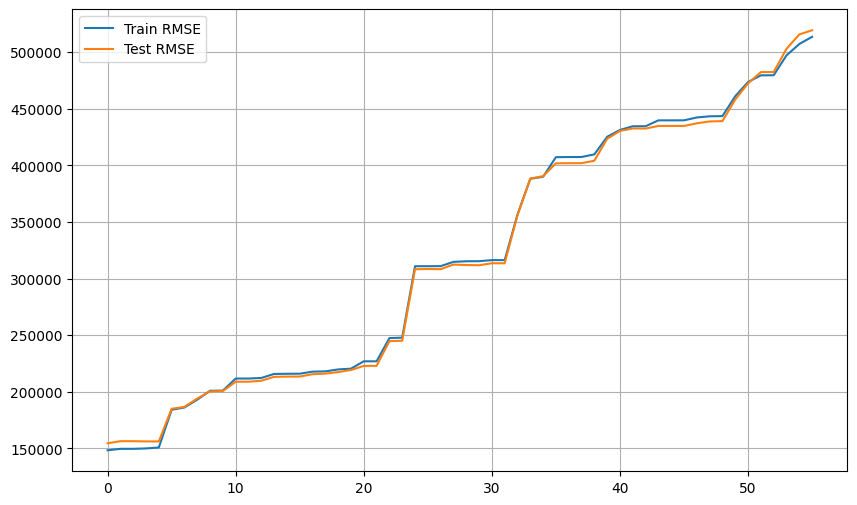

In [25]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]

DROP=[];b=[]

for i in range(len(Train_X_std.columns)):
    
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)

        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))
        
print('Dropped Features --> ',DROP)

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

# 모델링(modeling)

## 평가지표 함수 생성

In [26]:
columns=['Train-R2','Test-R2','Train-RSS','Test-RSS','Train-MSE','Test-MSE','Train-RMSE','Test-RMSE']
Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]),columns=columns)
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,2,replace=False)

def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

## 다중회귀

<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


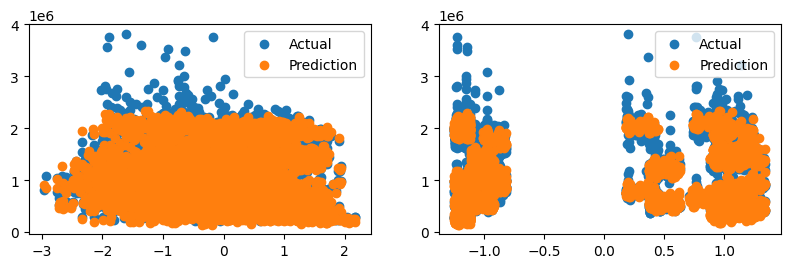



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9328296106281632
Residual Sum of Squares (RSS) on Training set  ---> 103518718391842.16
Mean Squared Error (MSE) on Training set       ---> 21738496092.365005
Root Mean Squared Error (RMSE) on Training set ---> 147439.80497940507

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9303017696577066
Residual Sum of Squares (RSS) on Training set  ---> 28393614754891.723
Mean Squared Error (MSE) on Training set       ---> 23840146729.54805
Root Mean Squared Error (RMSE) on Training set ---> 154402.54767829465

--------------------Residual Plots--------------------


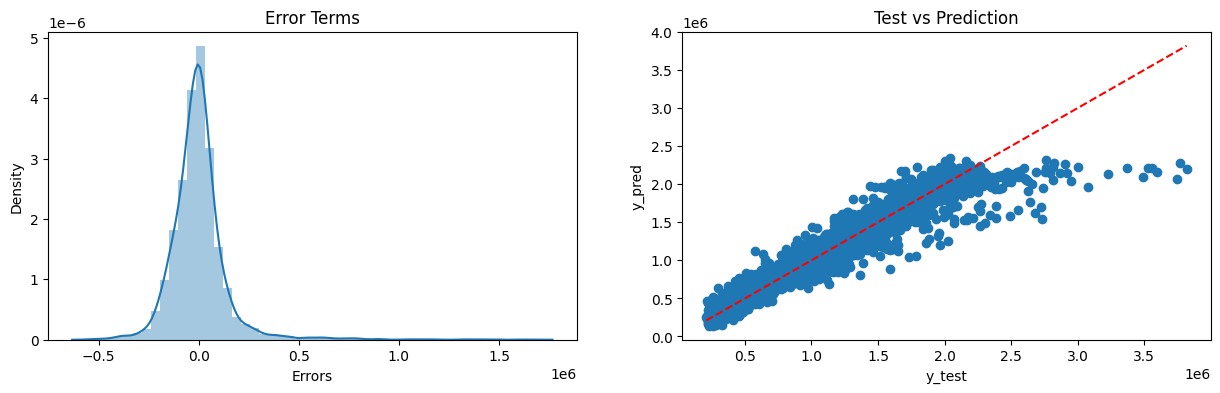

In [27]:
MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

## 릿지회귀

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


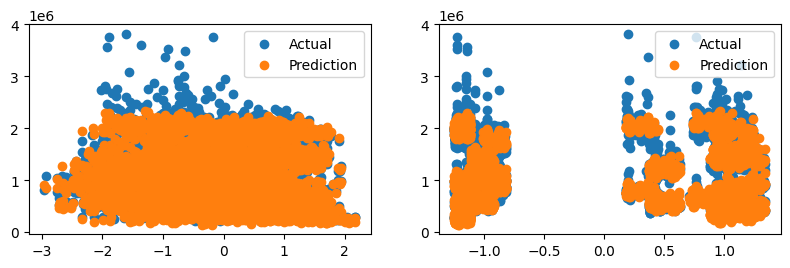



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9327801253729163
Residual Sum of Squares (RSS) on Training set  ---> 103594981909894.4
Mean Squared Error (MSE) on Training set       ---> 21754511110.85561
Root Mean Squared Error (RMSE) on Training set ---> 147494.1053427411

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9304286620592994
Residual Sum of Squares (RSS) on Training set  ---> 28341921419946.832
Mean Squared Error (MSE) on Training set       ---> 23796743425.648052
Root Mean Squared Error (RMSE) on Training set ---> 154261.93122623628

--------------------Residual Plots--------------------


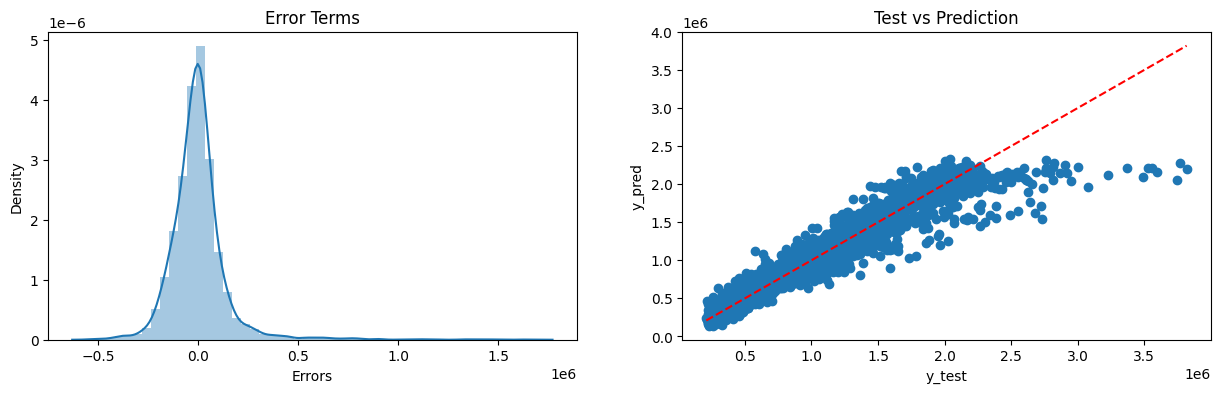

In [28]:
RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

## 라쏘 회귀

<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


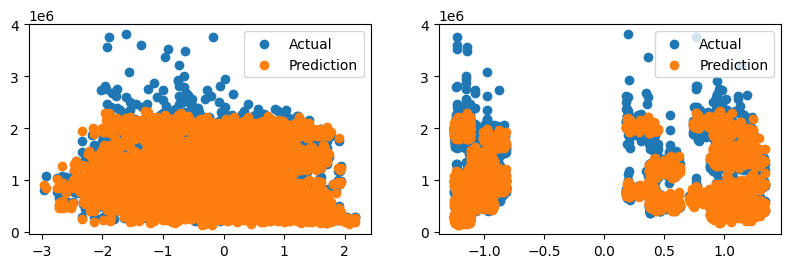



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9327484747343231
Residual Sum of Squares (RSS) on Training set  ---> 103643759854671.9
Mean Squared Error (MSE) on Training set       ---> 21764754274.39561
Root Mean Squared Error (RMSE) on Training set ---> 147528.82523220882

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9304289771466503
Residual Sum of Squares (RSS) on Training set  ---> 28341793059889.383
Mean Squared Error (MSE) on Training set       ---> 23796635650.620808
Root Mean Squared Error (RMSE) on Training set ---> 154261.5819010709

--------------------Residual Plots--------------------


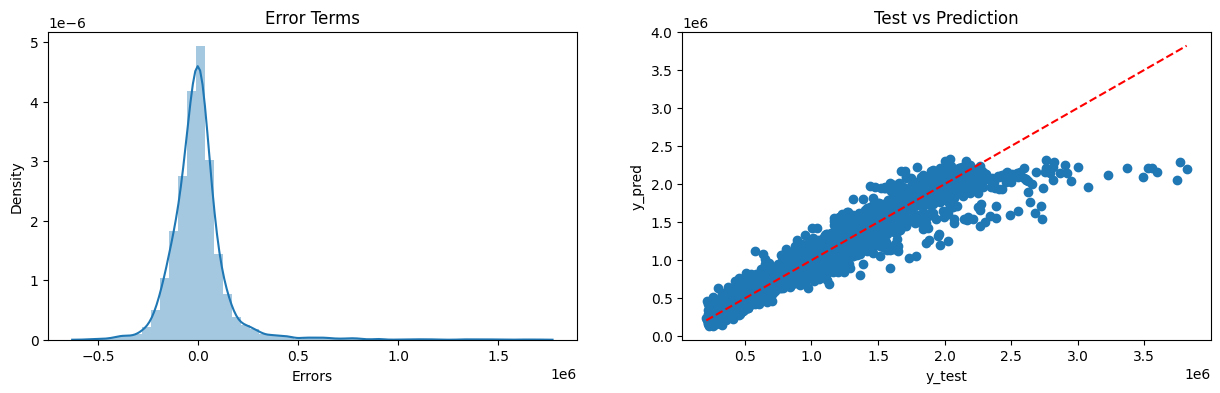

In [29]:
LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

## 엘라스틱넷 회귀

<<<----------------------------------- Evaluating Elastic-Net Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


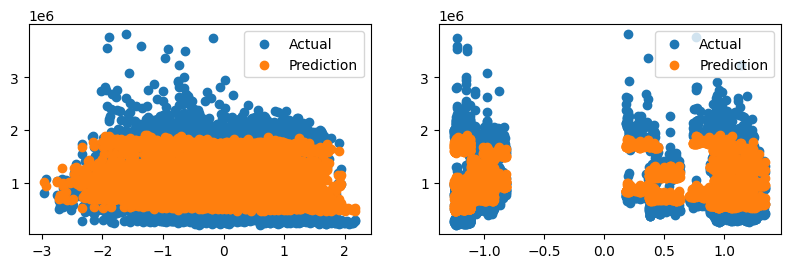



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.8137405142737946
Residual Sum of Squares (RSS) on Training set  ---> 287051235388322.4
Mean Squared Error (MSE) on Training set       ---> 60279553840.470894
Root Mean Squared Error (RMSE) on Training set ---> 245518.94802737908

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.815841056737556
Residual Sum of Squares (RSS) on Training set  ---> 75022537343948.1
Mean Squared Error (MSE) on Training set       ---> 62991215234.213356
Root Mean Squared Error (RMSE) on Training set ---> 250980.5076778142

--------------------Residual Plots--------------------


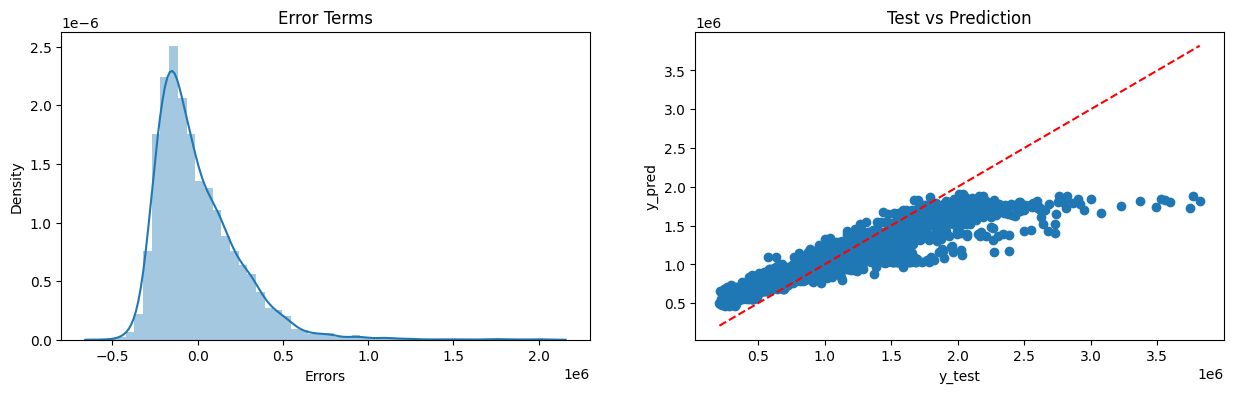

In [30]:
ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

## 다항(polynomial)회귀

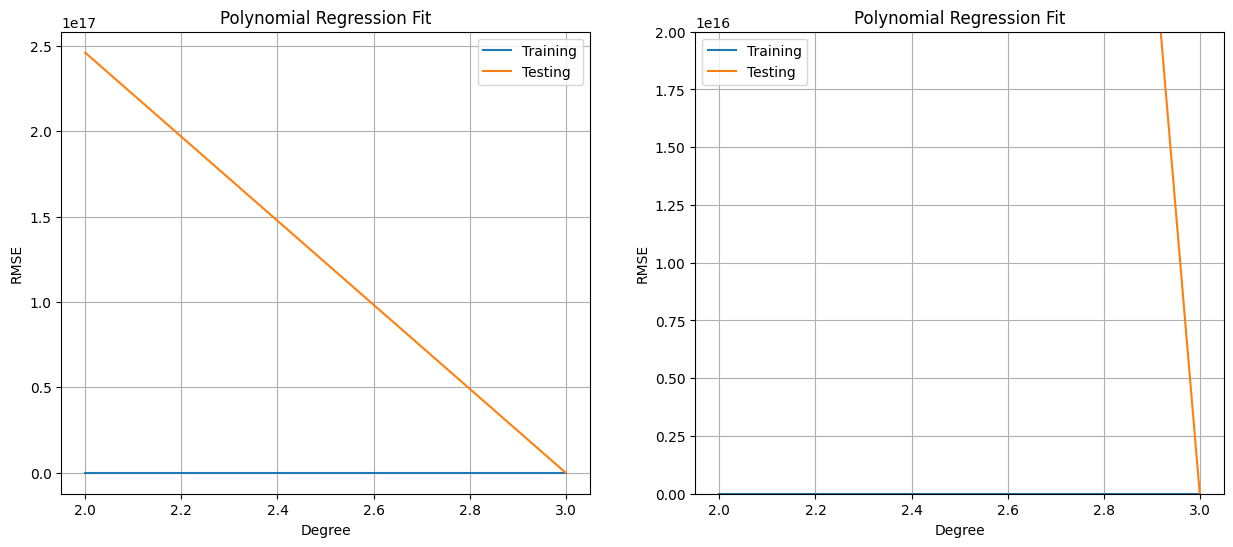

In [31]:
# various degrees에서 performance 확인

Trr=[]; Tss=[]
n_degree=4

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)
    
    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')

plt.title('Polynomial Regression Fit')

plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([0,2e16])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()
plt.show()

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [   3435.79335565  -10914.64725803    4743.1403851   480582.61947727
  -60957.46755428  -30853.06569609  -70053.06421042    5298.18798047
  -11439.58286696  -13971.09128277  -16682.38674897  -12878.73710242
   -2292.83208474   28688.66514407   20184.61268466   20988.70814859
   22136.91951839   31592.44847738   19045.48814114   24450.25914354
   12307.58606646   16964.13937984   41316.13527305   62408.71207801
   55223.44198641 -184149.60630621  217287.3296298  -191432.43688823
   -9300.07974756 -105821.4808743  -120951.75707304 -163526.10852509
  217950.5039817   -40433.22685236   39645.7444887   223055.62594847
  131867.72296706    8382.11323863 -129777.84828956   51459.25405503
   87968.22878722  133612.12244755   93290.45823604 -121281.87572729
   67461.22478578   87415.76570356  124035.8303268  -125925.7954409

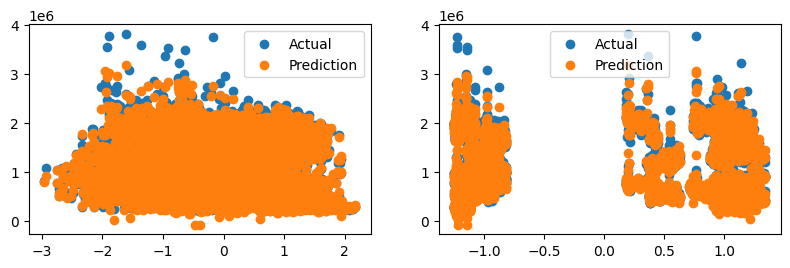



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9790542642222055
Residual Sum of Squares (RSS) on Training set  ---> 32280231568831.02
Mean Squared Error (MSE) on Training set       ---> 6778713055.193411
Root Mean Squared Error (RMSE) on Training set ---> 82332.94028026334

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> -1.768270843813802e+23
Residual Sum of Squares (RSS) on Training set  ---> 7.203568996656449e+37
Mean Squared Error (MSE) on Training set       ---> 6.048336689048235e+34
Root Mean Squared Error (RMSE) on Training set ---> 2.4593366359748787e+17

--------------------Residual Plots--------------------


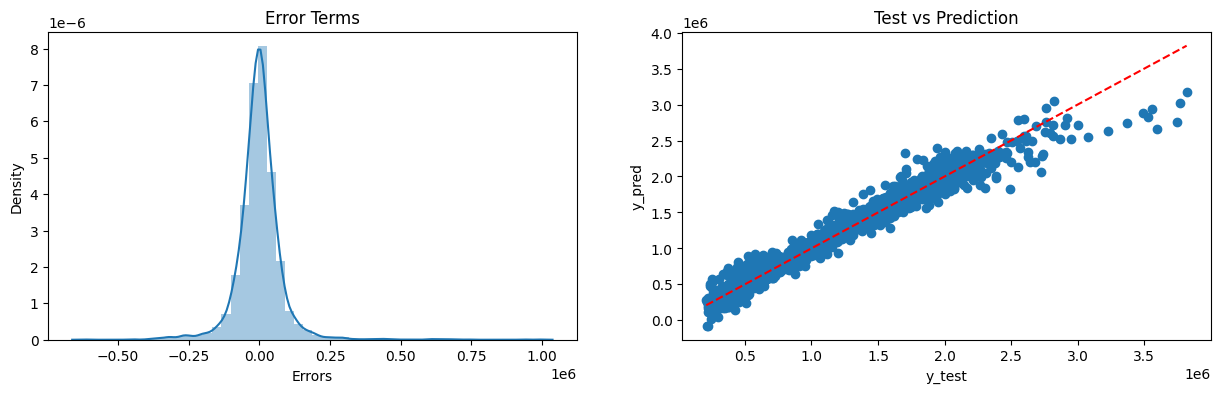

In [32]:
# degree=2로 결정

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

## 모델별 평가지표 확인

In [33]:
EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)']
EMC

,Train-R2,Test-R2,Train-RSS,Test-RSS,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
Multiple Linear Regression (MLR),0.932830,9.303018e-01,1.035187e+14,2.839361e+13,2.173850e+10,2.384015e+10,147439.804979,1.544025e+05
Ridge Linear Regression (RLR),0.932780,9.304287e-01,1.035950e+14,2.834192e+13,2.175451e+10,2.379674e+10,147494.105343,1.542619e+05
Lasso Linear Regression (LLR),0.932748,9.304290e-01,1.036438e+14,2.834179e+13,2.176475e+10,2.379664e+10,147528.825232,1.542616e+05
Elastic-Net Regression (ENR),0.813741,8.158411e-01,2.870512e+14,7.502254e+13,6.027955e+10,6.299122e+10,245518.948027,2.509805e+05
Polynomial Regression (PNR),0.979054,-1.768271e+23,3.228023e+13,7.203569e+37,6.778713e+09,6.048337e+34,82332.940280,2.459337e+17


# R2 스코어 비교

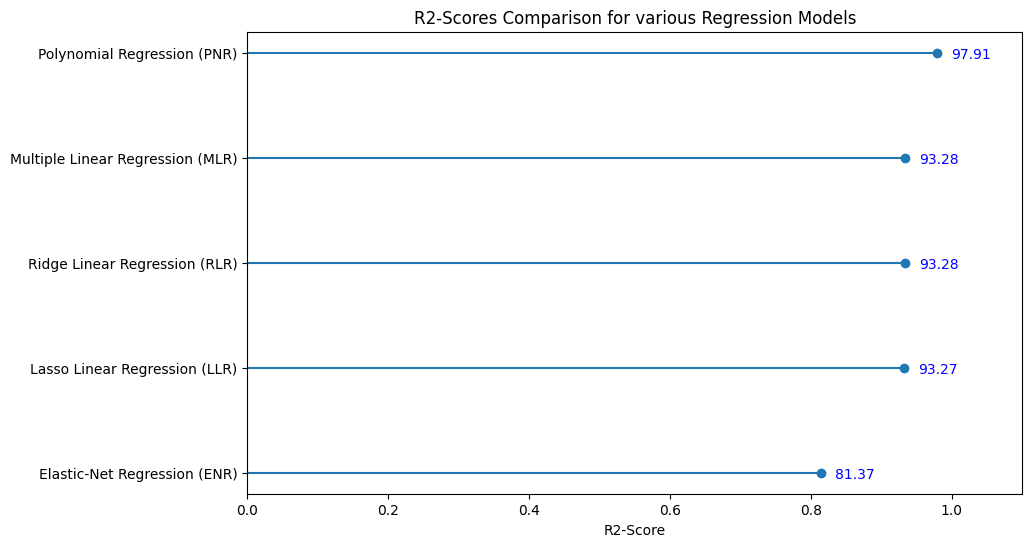

In [34]:
R2 = round(EMC['Train-R2'].sort_values(ascending=True),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
#plt.ylabel('Regression Models')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()

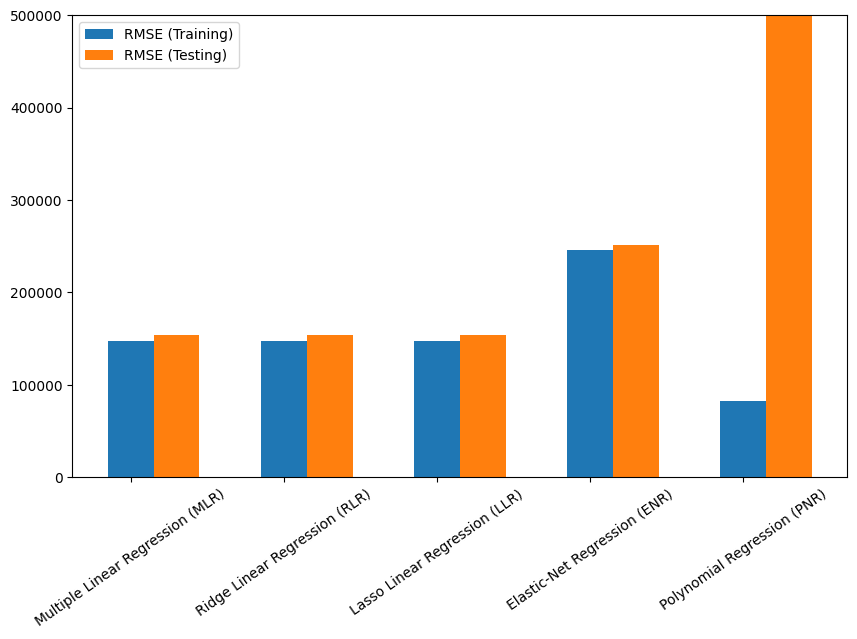

In [35]:
# RMSE 비교

cc = Model_Evaluation_Comparison_Matrix.columns.values
s=5

plt.bar(np.arange(5), Model_Evaluation_Comparison_Matrix[cc[6]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(5)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(5),EMC.index, rotation =35)
plt.legend()
plt.ylim([0,500000])
plt.show()

- 다항회귀는 오버피팅 된 걸 볼 수 있음!   
(RMSE값이 낮은 건 좋은 거지만, train과 test셋 사이의 RMSE값 차이가 크면 안됨)
- 단순 다중선형회귀가 가장 제일 좋은 성과

# 결론